# Atividade 6
Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

# Resposta Parágrafo

Em resumo, o método Arvore do ScikitLearn é completo pois consegue dividir a Heuristica do nó considerando os eixos X e Y, O método proposto nos vídeos considera o melhor valor dividindo-o no Eixo X, entretanto nas bases que encontrei a melhor forma de divisão seria considerando o eixo Y, uma vez que os target estão consideravelmente distantes um dos outros. Deste modo, não podemos definir qual seria a melhor heuristica pois cada Dataset apresentará resultados diferentes para cada Algoritmo.

# Algoritmos

## Bibliotecas e Funções

In [1]:
# Bibliotecas
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import accuracy_score


In [2]:
# Função para gráfico
import matplotlib.pyplot as plt
import pandas as pd

def plotDecisao(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.title(f'{title}')
    plt.show()



## Base de Dados iris

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target[:]

## Heuristicas, SkLearn, Video e Matheus

### Heuristica do ScikitLearnn

In [4]:
from sklearn import tree

ArvoreSK = tree.DecisionTreeClassifier() # DecisionTreeRegressor()

ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

(0.9933333333333333,)

In [5]:
# Validação Cruzada.
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresSK['test_score'])

[-0.18257419 -0.18257419 -0.31622777 -0.25819889 -0.        ]


### Heuristica do vídeo Passado

In [6]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2) # Resultado = 0, quer dizer que é puro
    return result

def impurezaValor(x, y, valor):
    iguais = x==valor
    impurezaIguais = impureza(y[iguais])
    propIguais = sum(iguais)/len(y)
    impurezaDiferentes = impureza(y[~iguais])
    propDiferentes = sum(~iguais)/len(y)
    impurezaTotal = propIguais*impurezaIguais + propDiferentes*impurezaDiferentes
    return impurezaTotal

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreVD(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreVD()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreVD()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

0.9533333333333334

In [7]:
# Validação Cruzada.
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresVD['test_score'])

[-0.25819889 -0.25819889 -0.4472136  -0.25819889 -0.        ]


### Heuristica Matheus

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

# A alteração está aqui.
# Para base que escolhi a melhor classificação seria pelo y e não pelo x.

def melhorValor(x, y): 
    result = None
    menorImpureza = float('inf')
    ymax = np.max(y)
    ymin = np.min(y)
    while True:
        valor = (ymin+ymax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                ymin = valor
            else:
                ymax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreMT(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreMT()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreMT()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.96

In [9]:
# Validação Cruzada.
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresMT['test_score'])

[-0.18257419 -0.18257419 -0.25819889 -0.25819889 -0.18257419]


## Comparação de Resultados

In [10]:
# Acurácia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.9933333333333333,)
Acurácia Cruzada Heuristica Vídeo       : 0.9533333333333334
Acurácia Cruzada Heuristica Matheus     : 0.96


In [11]:
# Validação Cruzada
print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-0.18257419 -0.18257419 -0.31622777 -0.25819889 -0.        ]
Validação Cruzada Heuristica Vídeo       : [-0.25819889 -0.25819889 -0.4472136  -0.25819889 -0.        ]
Validação Cruzada Heuristica Matheus     : [-0.18257419 -0.18257419 -0.25819889 -0.25819889 -0.18257419]


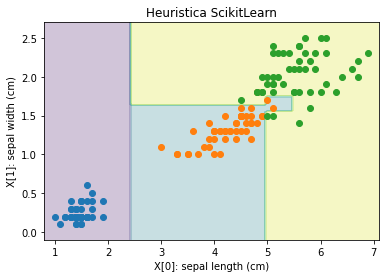

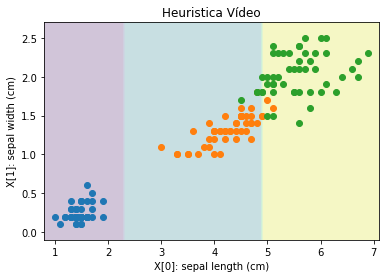

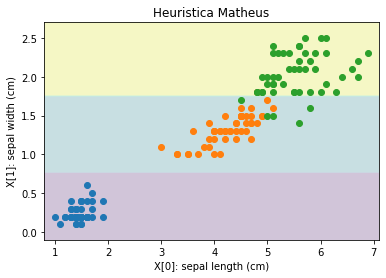

In [12]:
# Gráficos dos métodos heurísticos
plotDecisao(tree.DecisionTreeClassifier(), X, y, "Heuristica ScikitLearn")
plotDecisao(ArvoreVD(), X, y, "Heuristica Vídeo")
plotDecisao(ArvoreMT(), X, y, "Heuristica Matheus")

## Resultados com Outras bases de Dados

In [13]:
# Heuristica Matheus
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

# A alteração está aqui.
# Para base que escolhi a melhor classificação seria pelo y e não pelo x.

def melhorValor(x, y): 
    result = None
    menorImpureza = float('inf')
    ymax = np.max(y)
    ymin = np.min(y)
    while True:
        valor = (ymin+ymax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                ymin = valor
            else:
                ymax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        #valor, imp = melhorValor(X[:,caracteristica], y)
        valor, imp = melhorValor(X, y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreMT(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreMT()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreMT()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


### Base 1 - Acelerometer

In [14]:
# Base de classificação com atributos continuos
# https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00611/accelerometer.csv')
df

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121
...,...,...,...,...,...
152995,3,100,1.051,0.090,-0.262
152996,3,100,0.918,0.039,-0.129
152997,3,100,1.156,-0.094,-0.227
152998,3,100,0.934,0.203,-0.172


In [15]:
# Abrir as chaves 
df.keys

<bound method NDFrame.keys of         wconfid  pctid      x      y      z
0             1     20  1.004  0.090 -0.125
1             1     20  1.004 -0.043 -0.125
2             1     20  0.969  0.090 -0.121
3             1     20  0.973 -0.012 -0.137
4             1     20  1.000 -0.016 -0.121
...         ...    ...    ...    ...    ...
152995        3    100  1.051  0.090 -0.262
152996        3    100  0.918  0.039 -0.129
152997        3    100  1.156 -0.094 -0.227
152998        3    100  0.934  0.203 -0.172
152999        3    100  1.199 -0.176  0.109

[153000 rows x 5 columns]>

In [16]:
# Quantidade dos dados
df.shape

(153000, 5)

In [17]:
# Divisão em Dados e Target
X, y = df.pctid, df.wconfid

X.shape, y.shape, set(y) # temos 3 variaveis

((153000,), (153000,), {1, 2, 3})

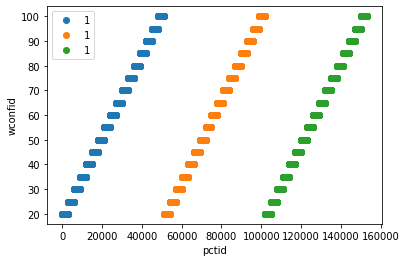

In [18]:
# Plotar gráfico
plt.xlabel(f"pctid")
plt.ylabel(f"wconfid")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
plt.legend()
plt.show()

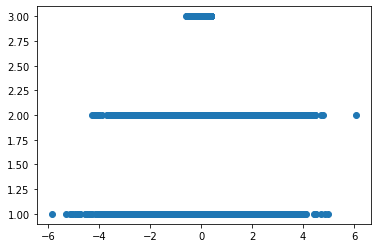

In [19]:
X2 = df["z"].values
y2 = df["wconfid"].values

plt.scatter(X2,y2)
plt.show()

In [20]:
# Função Reshape
X = X2.reshape(-1,1)
y = y2.reshape(-1,1)
y

array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]], dtype=int64)

In [21]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.34239869281045754

In [22]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.4971437908496732,)
Acurácia Cruzada Heuristica Vídeo       : 0.4971437908496732
Acurácia Cruzada Heuristica Matheus     : 0.34239869281045754


In [23]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-1.28866349 -1.16975781 -0.9363746  -0.95785367 -0.99998366]
Validação Cruzada Heuristica Vídeo       : [-1.28866349 -1.16975781 -0.9363746  -0.95785367 -0.9996568 ]
Validação Cruzada Heuristica Matheus     : [-1.29099445 -1.29099445 -1.29099445 -1.27674013 -1.23367775]


### Base 2 - Breast Cancer Coimbra Data Set

In [24]:
import pandas as pd
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data")
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv")
df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


In [25]:
df.keys()

Index(['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1', 'Classification'],
      dtype='object')

In [26]:
X, y = df.Age, df.Classification

X.shape, y.shape, set(y) # temos 3 variaveis

((116,), (116,), {1, 2})

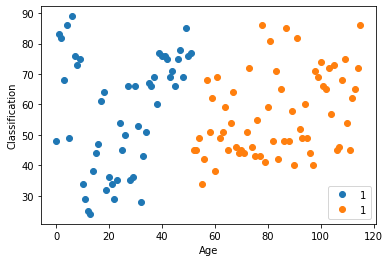

In [27]:
import matplotlib.pyplot as plt
# Plotar gráfico
plt.xlabel(f"Age")
plt.ylabel(f"Classification")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
plt.legend()
plt.show()

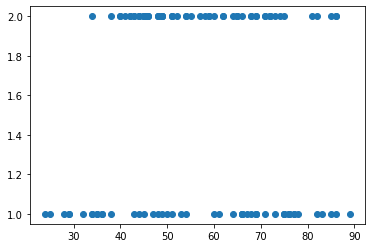

In [28]:
X2 = df["Age"].values
y2 = df["Classification"].values

plt.scatter(X2,y2)
plt.show()

In [29]:
# Função Reshape
X = X2.reshape(-1,1)
y = y2.reshape(-1,1)
y

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
    

In [30]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.5517241379310345

In [31]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.8189655172413793,)
Acurácia Cruzada Heuristica Vídeo       : 0.8189655172413793
Acurácia Cruzada Heuristica Matheus     : 0.5517241379310345


In [32]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-0.73598007 -0.55167728 -0.72231512 -0.58976782 -0.62554324]
Validação Cruzada Heuristica Vídeo       : [-0.73598007 -0.55167728 -0.72231512 -0.62554324 -0.62554324]
Validação Cruzada Heuristica Matheus     : [-0.6770032  -0.69156407 -0.65938047 -0.65938047 -0.65938047]


### Base 3 - TUANDROMD ( Tezpur University Android Malware Dataset) Data Set

In [33]:
import pandas as pd
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00476/buddymove_holidayiq.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00523/Exasens.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00485/google_review_ratings.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00622/TUANDROMD.csv")
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00476/buddymove_holidayiq.csv")
df

,User Id,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,User 1,2,77,79,69,68,95
1,User 2,2,62,76,76,69,68
2,User 3,2,50,97,87,50,75
3,User 4,2,68,77,95,76,61
4,User 5,2,98,54,59,95,86
...,...,...,...,...,...,...,...
244,User 245,18,139,148,129,129,168
245,User 246,22,114,228,104,84,168
246,User 247,20,124,178,104,158,174
247,User 248,20,133,149,139,144,213


In [34]:
y, X = df.Sports, df.Nature

X.shape, y.shape, set(y) # temos 3 variaveis

((249,), (249,), {2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25})

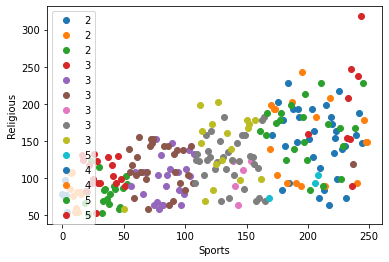

In [35]:
import matplotlib.pyplot as plt
# Plotar gráfico
plt.xlabel(f"Sports")
plt.ylabel(f"Religious")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
plt.legend()
plt.show()

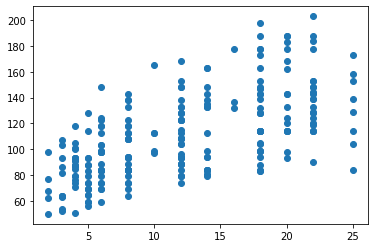

In [36]:
X2 = df["Sports"].values
y2 = df["Religious"].values

plt.scatter(X2,y2)
plt.show()

In [37]:
# Função Reshape
X = X2.reshape(-1,1)
y = y2.reshape(-1,1)

In [38]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.06827309236947791

In [39]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.18473895582329317,)
Acurácia Cruzada Heuristica Vídeo       : 0.18473895582329317
Acurácia Cruzada Heuristica Matheus     : 0.06827309236947791


In [40]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validação Cruzada Heuristica ScikitLearn : [-38.31605408 -27.2572926  -35.38502508 -38.85871846 -29.1935833 ]
Validação Cruzada Heuristica Vídeo       : [-35.93048845 -27.20183817 -30.62058131 -37.94654134 -31.13335373]
Validação Cruzada Heuristica Matheus     : [-46.12678181 -38.57486228 -42.38702632 -38.81211151 -40.59506354]
